In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

In [2]:
import numpy as np
import pandas as pd
import torch
from pathlib import PosixPath
from PIL import Image

from classification import *

Global seed set to 10


In [3]:
if not PosixPath('data_for_achive').exists():
    !yadisk https://disk.yandex.ru/d/H_an1US56uKIKQ
    !unzip count_animals.zip
    !unzip count_animals/data

In [4]:
train_path = PosixPath('data_for_achive/train')

In [5]:
labeling = pd.read_csv(train_path / 'answers.csv')
labeling.columns = ['filename', 'count']
print(labeling.shape)
labeling.head()

(10000, 2)


,filename,count
0,train_0000.png,2
1,train_0001.png,3
2,train_0002.png,4
3,train_0003.png,1
4,train_0004.png,4


torch.Size([100, 100, 4])


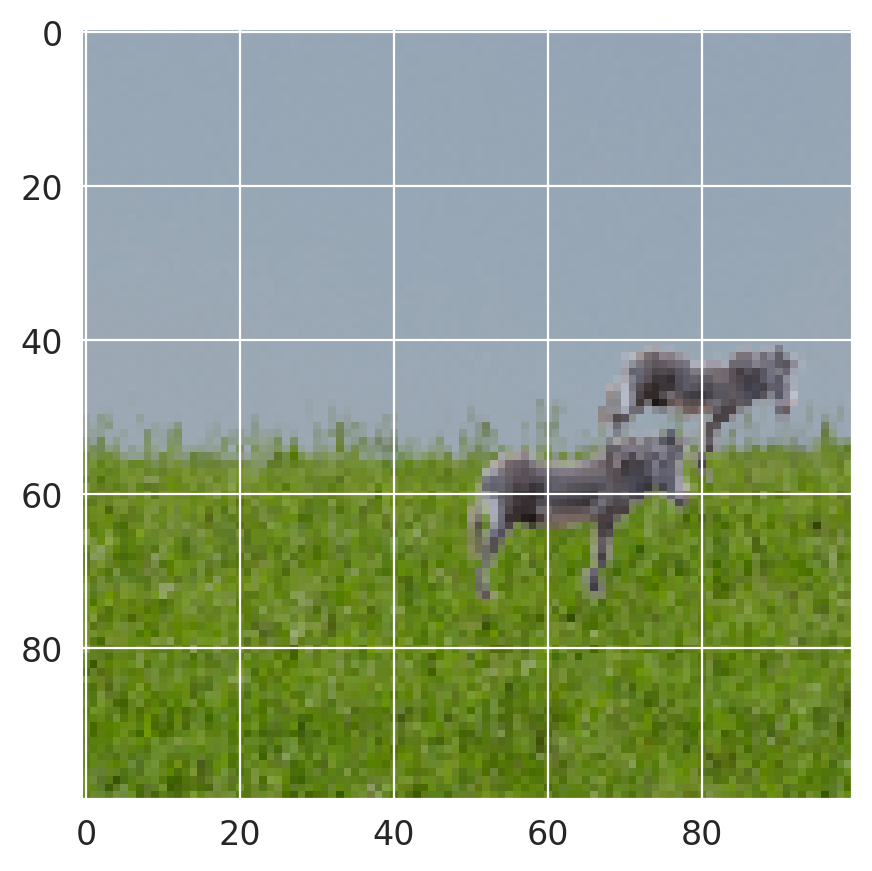

In [8]:
img_path = train_path / 'pictures' / 'train_0000.png'
img = torch.from_numpy(np.array(Image.open(img_path)))
print(img.shape)
plt.imshow(img);

In [9]:
def get_gt(data: pd.DataFrame):
    """Get dict {filename: count}"""
    train_gt = {}
    for idx, row in data.iterrows():
        train_gt[row['filename']] = row['count']

    return train_gt

In [10]:
from sklearn.model_selection import train_test_split

train_labeling, test_labeling = train_test_split(labeling, train_size=0.9, random_state=10)

train_gt = get_gt(train_labeling)
test_gt = get_gt(test_labeling)

print(len(train_gt))
print(len(test_gt))

9000
1000


In [11]:
train_dataset = ImgClassDataset(
    train_gt, 
    str(train_path / 'pictures'), 
    (160, 160),
    train=True,
    fast_train=False
)

test_dataset = ImgClassDataset(
    test_gt, 
    str(train_path / 'pictures'), 
    (160, 160),
    train=False,
    fast_train=False
)

In [12]:
train_loader = DataLoader(train_dataset, num_workers=4, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, num_workers=4, batch_size=50, shuffle=False)

In [13]:
train_labeling['count'].value_counts()

count
3    2595
4    1897
2    1896
1    1317
5    1295
Name: count, dtype: int64

In [14]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

model_checkpoint = ModelCheckpoint(
    dirpath="saved/",
    filename="{epoch}-{val_mae:.3f}",
    monitor="val_mae",
    mode="min",
    save_top_k=1,
)


model_lightning = ModelLightning(freeze='full')

trainer = pl.Trainer(
    max_epochs=5,
    accelerator='gpu',
    gradient_clip_val=0.5,
    callbacks=[model_checkpoint],
)

trainer.fit(
    model=model_lightning,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader,
)

/media/black_chick/Notes/HSE/CV_course/cv_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/media/black_chick/Notes/HSE/CV_course/cv_en

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [15]:
test_path = PosixPath('data_for_achive/test')
names_data = pd.read_csv(test_path / 'image_names.csv')

In [16]:
preds = classify('saved/epoch=3-val_mae=0.077.ckpt', test_path / 'pictures')

/media/black_chick/Notes/HSE/CV_course/cv_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:38<00:00, 50.60it/s]


In [17]:
pred_counts = []
for idx, row in names_data.iterrows():
    name = row['name']
    pred_counts.append(preds[name].round().astype('int32'))

In [18]:
result = pd.DataFrame({
    'count': pred_counts
})
result['count'] += 1
result.to_csv('result.csv', index=False)
result.head()

,count
0,1
1,4
2,5
3,4
4,2


In [19]:
result.value_counts()

count
3        1466
2        1139
4        1071
1         745
5         579
Name: count, dtype: int64